In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/earthquake-damage-in-nepal/NepalEarhquakeDamage2015.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# For logistic Regression

from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted


# For Decision Tree
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [3]:
df=pd.read_csv("../input/earthquake-damage-in-nepal/NepalEarhquakeDamage2015.csv")

In [4]:
df.head()

,building_id,district_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,damage_grade
0,120101000011,12,1,1,9,288,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Used in risk,Grade 3
1,120101000021,12,1,1,15,364,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Repaired and used,Grade 5
2,120101000031,12,1,1,20,384,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Repaired and used,Grade 2
3,120101000041,12,1,1,20,312,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Repaired and used,Grade 2
4,120101000051,12,1,1,30,308,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Repaired and used,Grade 1


In [5]:
#setting building_id to index
df.drop(columns="building_id", inplace=True)

**dropping leaky features**

In other to predict earthquake damage we'll drop the variables related to post-earthquake and keep the variables related to pre-earthquake

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762106 entries, 0 to 762105
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   district_id             762106 non-null  int64 
 1   count_floors_pre_eq     762106 non-null  int64 
 2   count_floors_post_eq    762106 non-null  int64 
 3   age_building            762106 non-null  int64 
 4   plinth_area_sq_ft       762106 non-null  int64 
 5   height_ft_pre_eq        762106 non-null  int64 
 6   height_ft_post_eq       762106 non-null  int64 
 7   land_surface_condition  762106 non-null  object
 8   foundation_type         762106 non-null  object
 9   roof_type               762106 non-null  object
 10  ground_floor_type       762106 non-null  object
 11  other_floor_type        762106 non-null  object
 12  position                762105 non-null  object
 13  plan_configuration      762105 non-null  object
 14  condition_post_eq       762106 non-n

In [7]:
drop_cols = []

for col in df.columns:
    
    if "post_eq" in col:
        drop_cols.append(col)


drop_cols 

['count_floors_post_eq', 'height_ft_post_eq', 'condition_post_eq']

In [8]:
df.drop(columns=drop_cols, inplace=True)

we will focus on **Ghorka district**, district_id=36

In [9]:
df = df[(df["district_id"] == 36)]

In [10]:
df.head(3)

,district_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,damage_grade
656563,36,2,4,280,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Grade 5
656605,36,1,15,120,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Attached-1 side,Rectangular,Grade 5
656626,36,2,25,300,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Grade 5


In [11]:
df.drop(columns="district_id", inplace=True)

**encoding our target damage_grade to binary**

In [12]:
# we should convert the variable to categorical encoded with 1 and 0
df["damage_grade"].value_counts()

Grade 5    27125
Grade 4    22536
Grade 3    15507
Grade 2     8555
Grade 1     4351
Name: damage_grade, dtype: int64

In [13]:
# we will label Grade 5 and Grande 4 as 1   (positive class)
# grade 1, 2, 3 as 0  (negative class)
df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
df.drop(columns="damage_grade", inplace=True)

# Explore

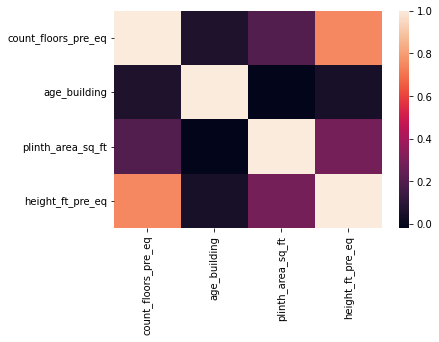

In [14]:
correlation = df[["count_floors_pre_eq","age_building","plinth_area_sq_ft","height_ft_pre_eq"]].corr()
sns.heatmap(correlation);

In [15]:
correlation

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq
count_floors_pre_eq,1.000000,0.062670,0.196953,0.749044
age_building,0.062670,1.000000,-0.019476,0.047666
plinth_area_sq_ft,0.196953,-0.019476,1.000000,0.286794
height_ft_pre_eq,0.749044,0.047666,0.286794,1.000000


we see from above that the number of floors is **correlated** with the height of the building so we decided to drop the count_floors_pre_eq feature

In [16]:
df.drop(columns="count_floors_pre_eq", inplace=True)

**boxplot for distribution of height_ft_pre_eq**

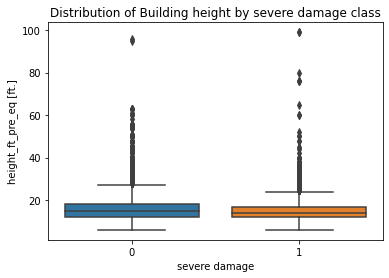

In [17]:
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df)
plt.xlabel("severe damage")
plt.ylabel("height_ft_pre_eq [ft.]")
plt.title("Distribution of Building height by severe damage class");

**Class Balance**

around 65% of the buildings were severe damaged, (severe=1  positive class,   majority class)

around 35% of the buildings wee not severe damaged, (severe=0  negative class,  minority class)

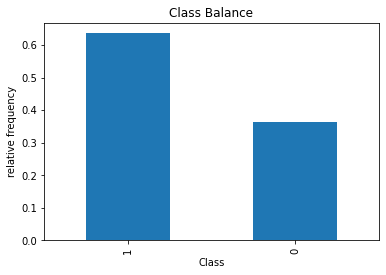

In [18]:
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="relative frequency", title="Class Balance"
);

In [19]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6360760304326665 0.3639239695673336


**Pivot table for foundation type**

In [20]:
foundation_pivot = pd.pivot_table(
    df, index="foundation_type", values="severe_damage", aggfunc=np.mean
)
foundation_pivot.sort_values(by="severe_damage")

,severe_damage
foundation_type,
RC,0.027134
Bamboo/Timber,0.321429
Cement-Stone/Brick,0.410200
Mud mortar-Stone/Brick,0.684101
Other,0.801020


only 2.7% of the buildings that have the foundation type RC (reinforced concrete) suffered severe danmage

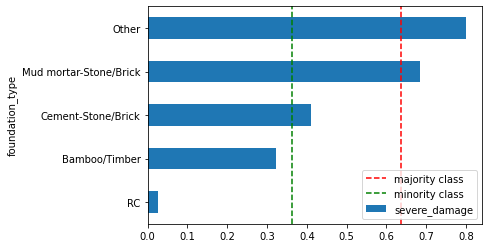

In [21]:
foundation_pivot.sort_values(by="severe_damage").plot(kind="barh", legend=None)
plt.axvline(
    majority_class_prop, linestyle="--", color="red", label="majority class"
)
plt.axvline(
    minority_class_prop, linestyle="--", color="green", label="minority class"
)
plt.legend(loc="lower right");

# Logistic Regression

**Split**

In [22]:
df.shape

(78074, 11)

In [23]:
target = "severe_damage"
X = df.drop(columns=target)
y=df[target]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train_shape", X_train.shape)
print("X_test_shape", X_test.shape)
print("y_train_shape", y_train.shape)
print("y_test_shape", X_test.shape)

X_train_shape (62459, 10)
X_test_shape (15615, 10)
y_train_shape (62459,)
y_test_shape (15615, 10)


**Communicate**

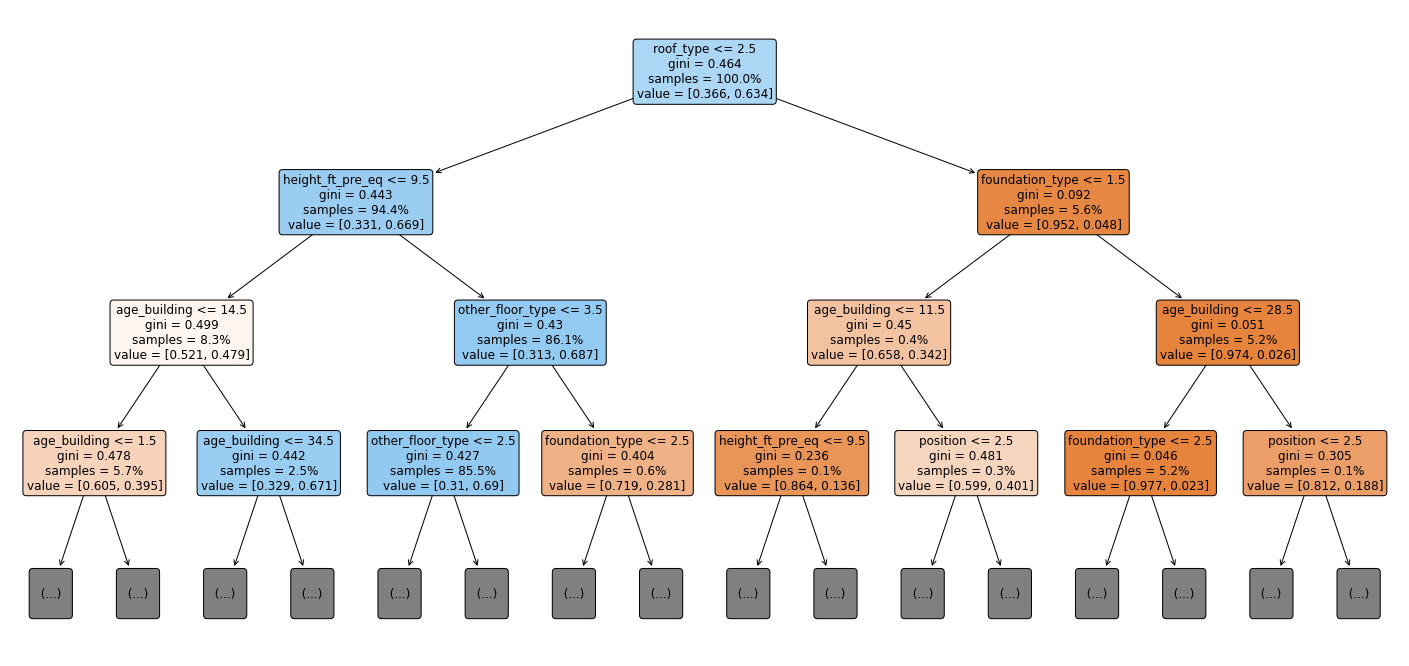

In [50]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree=model.named_steps["decisiontreeclassifier"],
    feature_names=X_train.columns,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

In [51]:
features = X_train.columns
importances = model.named_steps["decisiontreeclassifier"].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'], dtype='object')
Importances: [0.06712469 0.04628482 0.14590898]


In [52]:
feat_imp = pd.Series(importances,index=features)
feat_imp.head()

age_building              0.067125
plinth_area_sq_ft         0.046285
height_ft_pre_eq          0.145909
land_surface_condition    0.012790
foundation_type           0.062795
dtype: float64

 Create a horizontal bar chart with all the features in feat_imp. Be sure to label your x-axis **"Gini Importances"**

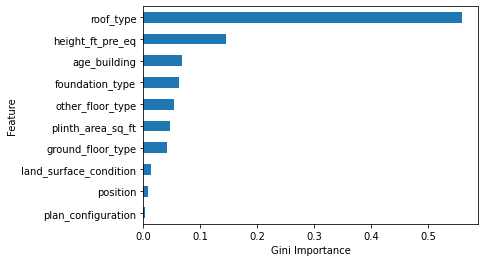

In [53]:
feat_imp.sort_values().plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature");

**This project was possible thanks to the lessons from Worldquant university data science lab**